# RouteZero UI process flow

This notebook illustrates a basic UI process flow (for our first minimal UI).

It's based off the design at

https://miro.com/app/board/uXjVO3_zrTA=/?share_link_id=573368594033

where this is up to:
- calculates energy consumption on routes but doesnt output a plot yet

what's missing up to this point:
- doesn't include option to input a sequence of routes
- loads a preprocessed gtfs file with no functionality for new gtfs zip file to be provided by user

# Step 1) read in preprocessed gtfs information
Could possibly have a list of files to select from

In [1]:
import RouteZero.gtfs as gtfs
import pandas as pd
import geopandas as gpd

trips_data = pd.read_csv('../data/gtfs/leichhardt/trip_data.csv')
# all route short names in the data
route_short_names_all = trips_data['route_short_name'].unique().tolist()
shapes = gpd.read_file('../data/gtfs/leichhardt/shapes.shp')

# step 2) User selects routes of interest

In [2]:
import ipywidgets as widgets

route_short_names = list(route_short_names_all)
route_selector = widgets.SelectMultiple(
    options=route_short_names,
    value=["305", "320", '389', '406',
                         '428', '430', '431', '433',
                         '437', '438N', '438X', '440',
                         '441', '442', '445', '469',
                         '470', '502', '503', '504'],
    #rows=10,
    description='Routes',
    disabled=False
)
display(route_selector)

SelectMultiple(description='Routes', index=(9, 22, 3639, 2114, 32, 33, 34, 35, 3645, 3632, 3634, 960, 3635, 34…

In [3]:
routes_sel = route_selector.value
assert len(routes_sel) > 0, 'must select at least one route'
print('The following routes have been selected:')
print(routes_sel)

The following routes have been selected:
('305', '320', '389', '406', '428', '430', '431', '433', '437', '438N', '438X', '440', '441', '442', '445', '469', '470', '502', '503', '504')


# step 3) user specifies other information

Define bus parameters

In [ ]:
from RouteZero.bus import Bus

# parameters that must be input
max_passengers = 70
battery_capacity = 400      # kWh
charging_rate = 200         # kW
gross_mass = 18000          # kg

# default parameters that they could optionally change
charging_efficiency=0.9
end_of_life_cap=0.8

bus = Bus(max_passengers, battery_capacity, charging_rate, gross_mass,
              charging_efficiency=charging_efficiency, end_of_life_cap=end_of_life_cap)

Specify charger power rating

In [ ]:
charger_max_power = 300         # kW

Specify peak passenger loading on each route
Ideally this would be a different value per route but I have used a single value for all here for simplicity

In [ ]:
patronage = {"route_short_name": routes_sel, "passengers":[38]*len(routes_sel)}

Optional adjustment of some default parameters

In [ ]:
deadhead = 0.1                # between trip deadhead time and energy (as a percentage ratio [0->1])
resolution = 10               # time binning resolution in minutes
min_charge_time = 60            # minimum time willing to plug a bus in to charge
reserve = 0.2                   # battery capacity to keep in reserve at all times percent [0-1]

# step 4) Calculate buses in traffic information and energy consumption on routes

First filter down to selected routes and calculate buses in traffic information. Plot this as a graph

In [ ]:
import RouteZero.route as route
import matplotlib.pyplot as plt

trips_data_sel = trips_data[trips_data['route_short_name'].isin(routes_sel)]

times, buses_in_traffic = route.calc_buses_in_traffic(trips_data_sel, deadhead=0.1, resolution=10)

plt.plot(times, buses_in_traffic)
plt.title('Buses on route throughout the week')
plt.ylabel('# buses')
plt.xlabel('hour of week')
plt.show()

print('Minimum number of buses required is ', buses_in_traffic.max())

In [ ]:
trips_data_sel = route.update_patronage(trips_data_sel, patronage)

Now calculate energy consumption for each route

In [ ]:
from RouteZero.models import LinearRegressionAbdelatyModel
model = LinearRegressionAbdelatyModel()
ec_km, ec_total = model.predict_worst_temp(trips_data_sel, bus)

Plot energy consumption of routes on map

In [ ]:
from RouteZero.map import create_map
map_title = "Route Energy Consumption between 0600 and 1200"
colorbar_str = 'energy per km'
m = create_map(trips_data_sel, shapes, ec_km, map_title, colorbar_str, window=[6, 12])
display(m)

# Step 5) Feasibility Optimisation

First solve the problem

In [ ]:
from RouteZero.optim import Feasibility_problem, plot_results

problem = Feasibility_problem(trips_data_sel, ec_total, bus, charger_max_power, start_charge=0.9, final_charge=0.9,
                              deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve, battery=None)

results = problem.solve()

Display / print results

In [ ]:


grid_limit = results['grid_limit']
chargers = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Minimum grid connection power rating is {} kW'.format(grid_limit))
print('Optimised charger configuration is: ')
print(chargers)
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)


Plot some daily summary of the charging

# Second pass calculations
Below is shown a few examples of what we could compute for the second finer detailed set of calculations.

We should decide which of these we are actually interested in including.

## Example 1 - Adding a battery
Adds a battery and reruns the feasibility optimisation to see what effect it has on the grid connection limit and the number of chargers required

In [ ]:
battery = {'power': 1000, 'capacity': 4000, 'efficiency': 0.95} # set to None to not have battery

problem = Feasibility_problem(trips_data_sel, ec_total, bus, charger_max_power, start_charge=0.9, final_charge=0.9, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve, battery=battery)

results = problem.solve()
grid_limit = results['grid_limit']
chargers = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Minimum grid connection power rating is {} kW'.format(grid_limit))
print('Optimised charger configuration is: ')
print(chargers)
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)

# Example 2 - Additional buses
Add additional buses so that this can be compared with previous results of adding battery (should be kind of similar)

In [ ]:
battery = None # set to None to not have battery
num_buses = 210 # must be greater than the maximum number of buses in traffic (198 in this case)

problem = Feasibility_problem(trips_data_sel, ec_total, bus, charger_max_power, start_charge=0.9, final_charge=0.9, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve, battery=None, num_buses=num_buses)

results = problem.solve()
grid_limit = results['grid_limit']
chargers = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Minimum grid connection power rating is {} kW'.format(grid_limit))
print('Optimised charger configuration is: ')
print(chargers)
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)

## Example 3 - Convenience charging:
user specifies all parameters and it produces the charging graph based on the goal of keeping the buses as
charged as possible

Takes about 10 secs to run without battery and 20 secs with battery

In [ ]:
from RouteZero.optim import Immediate_charge_problem

chargers = {'power': [50, 150], 'number': [20, 40]}
bus.charging_rate = 200
grid_power = 5000
battery = {'power': 1000, 'capacity': 4000, 'efficiency': 0.95} # set to None to not have battery
problem = Immediate_charge_problem(trips_data_sel, ec_total, bus, chargers, grid_power, start_charge=0.9,
                                   final_charge=0.8,
                                   deadhead=deadhead, resolution=resolution, min_charge_time=min_charge_time,
                                   reserve=reserve, battery=battery)

results = problem.solve()
plot_results(results, problem)

# Example 4 - Multiple charger sets:
User specifies multiple charger sets (power and number) as well as choosing a grid limit or specifying that the grid limit can be optimised. The number for each set can also be specified as 'optim' and then the 'cost' value will be used to relatively weight choosing more of each set.

In [ ]:
from RouteZero.optim import Extended_feas_problem
chargers = {'power': [40, 80, 150], 'number': ['optim', 'optim', 'optim'], 'cost':[10, 50, 100]}
grid_limit=4000 # can also set this to 'optim'
battery = {'power':1000, 'capacity':4000, 'efficiency':0.95}
problem = Extended_feas_problem(trips_data_sel, ec_total, bus, chargers, grid_limit, start_charge=0.9, final_charge=0.8, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve,battery=battery)

results = problem.solve()

print('Oprimised charger sets are: ')
print(results['chargers'])

plot_results(results, problem)



# Example 5 - determining battery capacity
Finds the battery capacity that reduces the grid connection requirement when the user has specified the chargers

In [ ]:
from RouteZero.optim import Battery_spec_problem

chargers = {'power': [50, 150], 'number': [20, 60]}
problem = Battery_spec_problem(trips_data_sel, ec_total, bus, chargers, battery_power=5000, start_charge=0.9, final_charge=0.8,deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve)

results = problem.solve()

print('Optimised battery capacity: ')
print(results['battery_spec'])
print('grid connection requirement: ', results['grid_limit'])
plot_results(results, problem)

# Second pass calculations
Below is shown a few examples of what we could compute for the second finer detailed set of calculations.

We should decide which of these we are actually interested in including.

## Example 1 - Adding a battery
Adds a battery and reruns the feasibility optimisation to see what effect it has on the grid connection limit and the number of chargers required

In [ ]:
battery = {'power': 1000, 'capacity': 4000, 'efficiency': 0.95} # set to None to not have battery

problem = Feasibility_problem(trips_data_sel, ec_total, bus, charger_max_power, start_charge=0.9, final_charge=0.9, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve, battery=battery)

results = problem.solve()
grid_limit = results['grid_limit']
chargers = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Minimum grid connection power rating is {} kW'.format(grid_limit))
print('Optimised charger configuration is: ')
print(chargers)
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)

# Example 2 - Additional buses
Add additional buses so that this can be compared with previous results of adding battery (should be kind of similar)

In [ ]:
battery = None # set to None to not have battery
num_buses = 210 # must be greater than the maximum number of buses in traffic (198 in this case)

problem = Feasibility_problem(trips_data_sel, ec_total, bus, charger_max_power, start_charge=0.9, final_charge=0.9, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve, battery=None, num_buses=num_buses)

results = problem.solve()
grid_limit = results['grid_limit']
chargers = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Minimum grid connection power rating is {} kW'.format(grid_limit))
print('Optimised charger configuration is: ')
print(chargers)
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)

## Example 3 - Convenience charging:
user specifies all parameters and it produces the charging graph based on the goal of keeping the buses as
charged as possible

Takes about 10 secs to run without battery and 20 secs with battery

In [ ]:
from RouteZero.optim import Immediate_charge_problem

chargers = {'power': [50, 150], 'number': [20, 40]}
bus.charging_rate = 200
grid_power = 5000
battery = {'power': 1000, 'capacity': 4000, 'efficiency': 0.95} # set to None to not have battery
problem = Immediate_charge_problem(trips_data_sel, ec_total, bus, chargers, grid_power, start_charge=0.9,
                                   final_charge=0.8,
                                   deadhead=deadhead, resolution=resolution, min_charge_time=min_charge_time,
                                   reserve=reserve, battery=battery)

results = problem.solve()
plot_results(results, problem)

# Example 4 - Multiple charger sets:
User specifies multiple charger sets (power and number) as well as choosing a grid limit or specifying that the grid limit can be optimised. The number for each set can also be specified as 'optim' and then the 'cost' value will be used to relatively weight choosing more of each set.

In [ ]:
from RouteZero.optim import Extended_feas_problem
chargers = {'power': [40, 80, 150], 'number': ['optim', 'optim', 'optim'], 'cost':[10, 50, 100]}
grid_limit=4000 # can also set this to 'optim'
battery = {'power':1000, 'capacity':4000, 'efficiency':0.95}
problem = Extended_feas_problem(trips_data_sel, ec_total, bus, chargers, grid_limit, start_charge=0.9, final_charge=0.8, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve,battery=battery)

results = problem.solve()

print('Oprimised charger sets are: ')
print(results['chargers'])

plot_results(results, problem)



# Example 5 - determining battery capacity
Finds the battery capacity that reduces the grid connection requirement when the user has specified the chargers

In [ ]:
from RouteZero.optim import Battery_spec_problem

chargers = {'power': [50, 150], 'number': [20, 60]}
problem = Battery_spec_problem(trips_data_sel, ec_total, bus, chargers, battery_power=5000, start_charge=0.9, final_charge=0.8,deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve)

results = problem.solve()

print('Optimised battery capacity: ')
print(results['battery_spec'])
print('grid connection requirement: ', results['grid_limit'])
plot_results(results, problem)

# Second pass calculations
Below is shown a few examples of what we could compute for the second finer detailed set of calculations.

We should decide which of these we are actually interested in including.

## Example 1 - Adding a battery
Adds a battery and reruns the feasibility optimisation to see what effect it has on the grid connection limit and the number of chargers required

In [ ]:
battery = {'power': 1000, 'capacity': 4000, 'efficiency': 0.95} # set to None to not have battery

problem = Feasibility_problem(trips_data_sel, ec_total, bus, charger_max_power, start_charge=0.9, final_charge=0.9, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve, battery=battery)

results = problem.solve()
grid_limit = results['grid_limit']
chargers = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Minimum grid connection power rating is {} kW'.format(grid_limit))
print('Optimised charger configuration is: ')
print(chargers)
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)

# Example 2 - Additional buses
Add additional buses so that this can be compared with previous results of adding battery (should be kind of similar)

In [ ]:
battery = None # set to None to not have battery
num_buses = 210 # must be greater than the maximum number of buses in traffic (198 in this case)

problem = Feasibility_problem(trips_data_sel, ec_total, bus, charger_max_power, start_charge=0.9, final_charge=0.9, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve, battery=None, num_buses=num_buses)

results = problem.solve()
grid_limit = results['grid_limit']
chargers = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Minimum grid connection power rating is {} kW'.format(grid_limit))
print('Optimised charger configuration is: ')
print(chargers)
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)

## Example 3 - Convenience charging:
user specifies all parameters and it produces the charging graph based on the goal of keeping the buses as
charged as possible

Takes about 10 secs to run without battery and 20 secs with battery

In [ ]:
from RouteZero.optim import Immediate_charge_problem

chargers = {'power': [50, 150], 'number': [20, 40]}
bus.charging_rate = 200
grid_power = 5000
battery = {'power': 1000, 'capacity': 4000, 'efficiency': 0.95} # set to None to not have battery
problem = Immediate_charge_problem(trips_data_sel, ec_total, bus, chargers, grid_power, start_charge=0.9,
                                   final_charge=0.8,
                                   deadhead=deadhead, resolution=resolution, min_charge_time=min_charge_time,
                                   reserve=reserve, battery=battery)

results = problem.solve()
plot_results(results, problem)

# Example 4 - Multiple charger sets:
User specifies multiple charger sets (power and number) as well as choosing a grid limit or specifying that the grid limit can be optimised. The number for each set can also be specified as 'optim' and then the 'cost' value will be used to relatively weight choosing more of each set.

In [ ]:
from RouteZero.optim import Extended_feas_problem
chargers = {'power': [40, 80, 150], 'number': ['optim', 'optim', 'optim'], 'cost':[10, 50, 100]}
grid_limit=4000 # can also set this to 'optim'
battery = {'power':1000, 'capacity':4000, 'efficiency':0.95}
problem = Extended_feas_problem(trips_data_sel, ec_total, bus, chargers, grid_limit, start_charge=0.9, final_charge=0.8, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve,battery=battery)

results = problem.solve()

print('Oprimised charger sets are: ')
print(results['chargers'])

plot_results(results, problem)



# Example 5 - determining battery capacity
Finds the battery capacity that reduces the grid connection requirement when the user has specified the chargers

In [ ]:
from RouteZero.optim import Battery_spec_problem

chargers = {'power': [50, 150], 'number': [20, 60]}
problem = Battery_spec_problem(trips_data_sel, ec_total, bus, chargers, battery_power=5000, start_charge=0.9, final_charge=0.8,deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve)

results = problem.solve()

print('Optimised battery capacity: ')
print(results['battery_spec'])
print('grid connection requirement: ', results['grid_limit'])
plot_results(results, problem)

# Second pass calculations
Below is shown a few examples of what we could compute for the second finer detailed set of calculations.

We should decide which of these we are actually interested in including.

## Example 1 - Adding a battery
Adds a battery and reruns the feasibility optimisation to see what effect it has on the grid connection limit and the number of chargers required

Minimum grid connection power rating is 3713.1273 kW
Optimised charger configuration is: 
{'power': [300], 'number': array([20.]), 'cost': [100]}
Unable to achieve desired final charge by 0.0 %


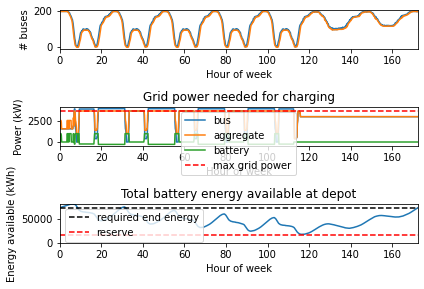

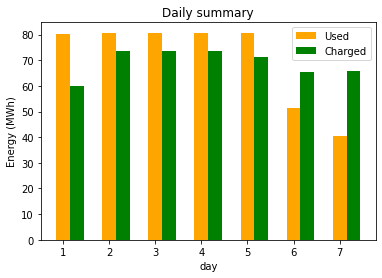

In [14]:
battery = {'power': 1000, 'capacity': 4000, 'efficiency': 0.95} # set to None to not have battery

problem = Feasibility_problem(trips_data_sel, ec_total, bus, charger_max_power, start_charge=0.9, final_charge=0.9, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve, battery=battery)

results = problem.solve()
grid_limit = results['grid_limit']
chargers = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Minimum grid connection power rating is {} kW'.format(grid_limit))
print('Optimised charger configuration is: ')
print(chargers)
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)

# Example 2 - Additional buses
Add additional buses so that this can be compared with previous results of adding battery (should be kind of similar)

Minimum grid connection power rating is 3413.4352 kW
Optimised charger configuration is: 
{'power': [300], 'number': array([18.]), 'cost': [100]}
Unable to achieve desired final charge by 0.0 %


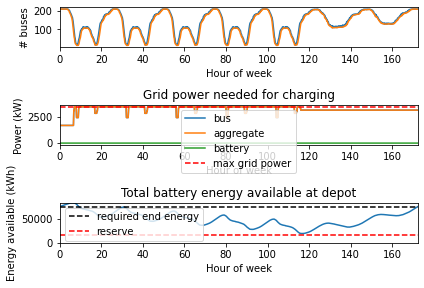

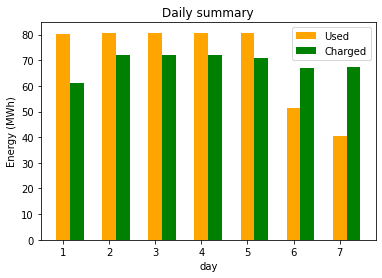

In [15]:
battery = None # set to None to not have battery
num_buses = 210 # must be greater than the maximum number of buses in traffic (198 in this case)

problem = Feasibility_problem(trips_data_sel, ec_total, bus, charger_max_power, start_charge=0.9, final_charge=0.9, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve, battery=None, num_buses=num_buses)

results = problem.solve()
grid_limit = results['grid_limit']
chargers = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Minimum grid connection power rating is {} kW'.format(grid_limit))
print('Optimised charger configuration is: ')
print(chargers)
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)

## Example 3 - Convenience charging:
user specifies all parameters and it produces the charging graph based on the goal of keeping the buses as
charged as possible

Takes about 10 secs to run without battery and 20 secs with battery

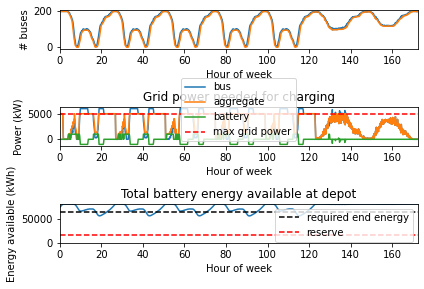

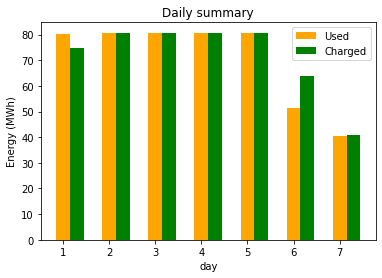

In [16]:
from RouteZero.optim import Immediate_charge_problem

chargers = {'power': [50, 150], 'number': [20, 40]}
bus.charging_rate = 200
grid_power = 5000
battery = {'power': 1000, 'capacity': 4000, 'efficiency': 0.95} # set to None to not have battery
problem = Immediate_charge_problem(trips_data_sel, ec_total, bus, chargers, grid_power, start_charge=0.9,
                                   final_charge=0.8,
                                   deadhead=deadhead, resolution=resolution, min_charge_time=min_charge_time,
                                   reserve=reserve, battery=battery)

results = problem.solve()
plot_results(results, problem)

# Example 4 - Multiple charger sets:
User specifies multiple charger sets (power and number) as well as choosing a grid limit or specifying that the grid limit can be optimised. The number for each set can also be specified as 'optim' and then the 'cost' value will be used to relatively weight choosing more of each set.

Oprimised charger sets are: 
{'power': [150, 80, 40], 'number': array([24.,  0., 18.]), 'cost': [100, 50, 10]}


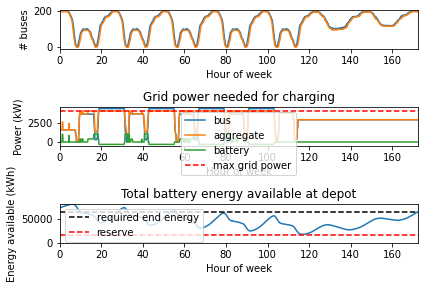

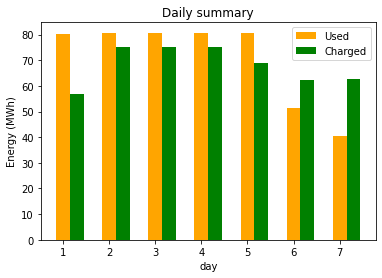

In [17]:
from RouteZero.optim import Extended_feas_problem
chargers = {'power': [40, 80, 150], 'number': ['optim', 'optim', 'optim'], 'cost':[10, 50, 100]}
grid_limit=4000 # can also set this to 'optim'
battery = {'power':1000, 'capacity':4000, 'efficiency':0.95}
problem = Extended_feas_problem(trips_data_sel, ec_total, bus, chargers, grid_limit, start_charge=0.9, final_charge=0.8, deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve,battery=battery)

results = problem.solve()

print('Oprimised charger sets are: ')
print(results['chargers'])

plot_results(results, problem)



# Example 5 - determining battery capacity
Finds the battery capacity that reduces the grid connection requirement when the user has specified the chargers

Optimised battery capacity: 
{'capacity': 5633.6643, 'power': 5000, 'efficiency': 0.95}
grid connection requirement:  3462.9313


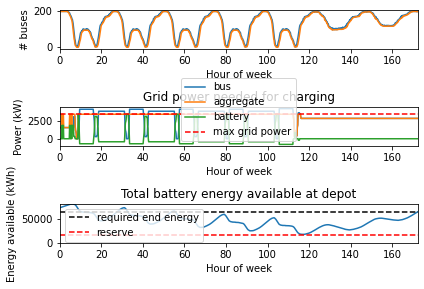

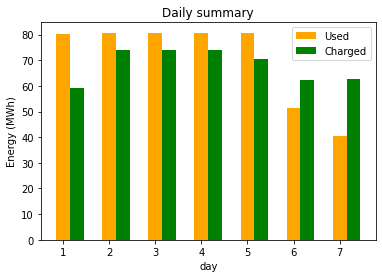

In [18]:
from RouteZero.optim import Battery_spec_problem

chargers = {'power': [50, 150], 'number': [20, 60]}
problem = Battery_spec_problem(trips_data_sel, ec_total, bus, chargers, battery_power=5000, start_charge=0.9, final_charge=0.8,deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve)

results = problem.solve()

print('Optimised battery capacity: ')
print(results['battery_spec'])
print('grid connection requirement: ', results['grid_limit'])
plot_results(results, problem)